# How to implement a min-cap constraint in MILP

$$
E_t = \min\big(E_{\max}, \; E_{t-1} + Eh_t  - Ec_t\big), \forall t \in \{1,\dots,T\}
$$

with $E_0 = \text{const}$.


### MILP Formulation

* Variables:

  * $E_t \in [0, E_{\max}]$ (continuous, energy at time $t$)
  * $\xi_t \in \{0,1\}$ (binary, indicates whether the cap $E_{\max}$ is binding at time $t$)

* Parameters:

  * $E_{\max}$ (capacity, constant)
  * $Eh_t = f(t)$   (energy harvested at time $t$)
  * $Ec_t = g(t)$   (energy consumed at time $t$)

#### Constraints

For all $t = 1,\dots,T$:

1. Upper bounds

$$
E_t \le E_{t-1} + Eh_t - Ec_t
$$

$$
E_t \le E_{\max}
$$

2. Big-M linking (with $M = E_{\max}$)

$$
E_t \ge E_{t-1} + Eh_t - Ec_t - E_{\max} \cdot \xi_t
$$

$$
E_t \ge E_{\max} - E_{\max}\cdot(1-\xi_t)
$$

3. Initial condition

$$
E_0 = \text{const}.
$$


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import pyomo.environ as pyo
import matplotlib.pyplot as plt

In [3]:
model = pyo.ConcreteModel()

Tmax = 200 # maximum time

Emax = 28  # maximum energy
E0_const = 5  # initial energy

In [4]:
# model variables

model.T = pyo.RangeSet(1, Tmax)
model.T_all = pyo.RangeSet(0, Tmax)   # includes 0

model.E = pyo.Var(model.T_all, within=pyo.NonNegativeReals, bounds=(0,Emax))
model.y = pyo.Var(model.T, within=pyo.Binary)

In [5]:
# Initial condition
model.E[0].fix(E0_const)

In [6]:
Eh = [random.randint(1, 5)  for t in model.T]  # energy harvested at time t
Ec = [random.randint(1, 5)  for t in model.T]  # energy consumed at time t


In [7]:
# for the system to be feasible with the values below, Emax must be at least 28 with E0 = 5

Eh = [5, 5, 1, 2, 5, 3, 1, 1, 5, 4, 1, 5, 3, 4, 5, 4, 4, 4, 4, 4, 4, 3, 2, 1, 4, 5, 1, 2, 2, 2, 1, 3, 1, 4, 2, 2, 4, 5, 5, 2, 3, 3, 4, 4, 5, 1, 2, 3, 1, 2, 1, 2, 4, 2, 3, 1, 1, 4, 3, 1, 3, 1, 2, 3, 3, 5, 2, 1, 3, 2, 5, 3, 5, 2, 3, 5, 3, 3, 4, 3, 4, 4, 4, 5, 1, 3, 2, 1, 5, 3, 1, 1, 4, 5, 4, 2, 2, 1, 2, 5, 5, 2, 2, 4, 5, 5, 5, 5, 3, 2, 5, 1, 1, 4, 1, 4, 1, 1, 1, 5, 3, 4, 2, 3, 5, 2, 5, 4, 3, 3, 5, 4, 1, 1, 1, 1, 4, 2, 4, 2, 2, 3, 4, 2, 2, 5, 4, 2, 3, 4, 1, 2, 4, 2, 1, 4, 4, 2, 1, 4, 4, 1, 1, 1, 4, 2, 4, 5, 3, 4, 4, 1, 4, 1, 3, 4, 3, 5, 3, 4, 4, 2, 4, 4, 1, 1, 2, 5, 5, 1, 4, 5, 2, 1, 3, 4, 3, 3, 2, 2]
Ec = [1, 3, 1, 4, 2, 1, 1, 1, 3, 4, 4, 5, 3, 3, 4, 2, 5, 3, 4, 3, 1, 5, 2, 1, 2, 2, 2, 3, 5, 4, 4, 5, 3, 1, 3, 3, 2, 2, 4, 1, 5, 3, 1, 4, 3, 4, 3, 4, 5, 4, 2, 5, 3, 1, 3, 3, 5, 1, 5, 2, 4, 2, 1, 2, 1, 1, 1, 4, 2, 2, 5, 1, 3, 1, 3, 4, 4, 3, 3, 4, 2, 2, 1, 1, 1, 4, 2, 1, 5, 4, 2, 4, 5, 1, 1, 3, 3, 1, 3, 2, 1, 2, 5, 5, 3, 2, 3, 1, 3, 2, 5, 1, 2, 4, 3, 2, 5, 2, 3, 3, 4, 5, 3, 2, 2, 3, 3, 4, 4, 5, 5, 1, 3, 2, 3, 3, 4, 1, 1, 3, 2, 3, 5, 4, 3, 3, 3, 4, 3, 5, 5, 1, 4, 2, 1, 4, 2, 2, 2, 1, 4, 1, 5, 4, 5, 3, 4, 2, 3, 3, 5, 4, 2, 4, 4, 5, 1, 2, 4, 3, 5, 3, 4, 2, 5, 5, 4, 3, 5, 3, 3, 1, 2, 4, 2, 4, 1, 5, 2, 2]

In [8]:
model.EnergyConstr = pyo.ConstraintList()
for t, Eh_t, Ec_t in zip(model.T, Eh, Ec):
    Et_prev = model.E[t-1]

    model.EnergyConstr.add(model.E[t] >= 0)

    # Upper bounds
    model.EnergyConstr.add(model.E[t] <= Et_prev + Eh_t - Ec_t)
    model.EnergyConstr.add(model.E[t] <= Emax)

    # Big-M linking
    model.EnergyConstr.add(model.E[t] >= Et_prev + Eh_t - Ec_t - Emax * model.y[t])
    model.EnergyConstr.add(model.E[t] >= Emax - Emax * (1 - model.y[t]))

In [9]:
# Objective: maximize sum of E(t)
model.Obj = pyo.Objective(expr=sum(model.E[t] for t in model.T),
                          sense=pyo.maximize)

In [10]:
# Solver (make sure you have glpk or cbc installed)
solver = pyo.SolverFactory("glpk")

# Solve
results = solver.solve(model, tee=True)
# Check solver status
print(results.solver.status)
print(results.solver.termination_condition)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp0b_hr2n0.glpk.raw --wglp /tmp/tmpnoztj6_y.glpk.glp --cpxlp
 /tmp/tmpmfifigoa.pyomo.lp
Reading problem data from '/tmp/tmpmfifigoa.pyomo.lp'...
/tmp/tmpmfifigoa.pyomo.lp:5408: warning: lower bound of variable 'x206' redefined
/tmp/tmpmfifigoa.pyomo.lp:5408: warning: upper bound of variable 'x206' redefined
1000 rows, 400 columns, 1798 non-zeros
200 integer variables, all of which are binary
5608 lines were read
Writing problem data to '/tmp/tmpnoztj6_y.glpk.glp'...
4601 lines were written
GLPK Integer Optimizer 5.0
1000 rows, 400 columns, 1798 non-zeros
200 integer variables, all of which are binary
Preprocessing...
173 constraint coefficient(s) were reduced
284 rows, 190 columns, 662 non-zeros
95 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  2.800e+01  ratio =  2.800e+01
GM: min|aij| =  8.633e-01  max|aij| =  1.158e+00  ratio =  1.342e+00
EQ: min|ai

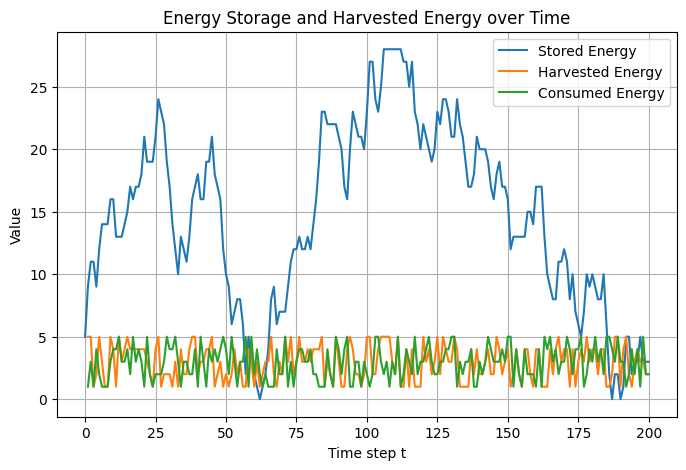

In [11]:
E_vals = [pyo.value(model.E[t]) for t in model.T_all]
ts = list(range(Tmax + 1))

plt.figure(figsize=(8, 5))
plt.plot(ts, E_vals, label="Stored Energy")
plt.plot(ts[1:], Eh, linestyle="-", label="Harvested Energy")
plt.plot(ts[1:], Ec, linestyle="-", label="Consumed Energy")
plt.xlabel("Time step t")
plt.ylabel("Value")
plt.title("Energy Storage and Harvested Energy over Time")
plt.legend()
plt.grid(True)
plt.show()


Look between t = 100 and t = 125 and you will see that the energy is capped at E_max = 30.

> Note that this is a simplified example and we are not controlling the consumed energy. In a real-world scenario, you you cannot consume energy if E_t = 0. So if you change Emax to a lower value, the system can become infeasible.